## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch with CUDA
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Install additional dependencies
# !pip install matplotlib pandas pillow torchtnt==0.2.0 tqdm tabulate

# # Install package for creating visually distinct colormaps
# !pip install distinctipy

# # Install utility packages
# !pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Import tqdm for progress bar
from tqdm.auto import tqdm

In [3]:
# !pip install pycocotools

In [4]:
from engine import evaluate

In [5]:
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

## Setting Up the Project

### Setting a Random Number Seed

In [6]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

### Setting the Device and Data Type

In [7]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

### Setting the Directory Paths

In [8]:
# The name for the project
project_name = f"pytorch-mask-r-cnn-instance-segmentation"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# Define path to store datasets
dataset_dir = Path("./Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

pd.Series({
    "Project Directory:": project_dir, 
    "Dataset Directory:": dataset_dir
}).to_frame().style.hide(axis='columns')

## Loading and Exploring the Dataset

### Setting the Dataset Path

In [9]:
# Set the name of the dataset
dataset_name = 'pytorch-for-information-extraction'

# Construct the GitHub repository name 
gh_repo = f'cj-mills/{dataset_name}'

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}/code/datasets/detection/student-id/')

pd.Series({
    "GitHub Repository:": gh_repo, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

### Downloading the Dataset

In [10]:
# Clone the dataset repository from GitHub
!git clone {f'https://github.com/{gh_repo}.git'} {dataset_dir/dataset_name}

fatal: destination path 'Datasets/pytorch-for-information-extraction' already exists and is not an empty directory.


### Getting the Image and Annotation Files

In [11]:
# Get a list of image files in the dataset
img_file_paths = get_img_files(dataset_path)

# Get a list of JSON files in the dataset
annotation_file_paths = list(dataset_path.glob('*.json'))

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image File": [file.name for file in img_file_paths], 
              "Annotation File":[file.name for file in annotation_file_paths]}).head()

Image File Annotation File
0  10001.jpg      10001.json
1  10002.jpg      10002.json
2  10003.jpg      10003.json
3  10004.jpg      10004.json
4  10005.jpg      10005.json

### Get Image File Paths

In [12]:
# Create a dictionary that maps file names to file paths
img_dict = {file.stem : file for file in img_file_paths}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 150


0
10001  Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10001.jpg
10002  Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10002.jpg
10003  Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10003.jpg
10004  Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10004.jpg
10005  Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10005.jpg

### Get Image Annotations

In [13]:
# Create a generator that yields Pandas DataFrames containing the data from each JSON file
cls_dataframes = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_file_paths))

# Concatenate the DataFrames into a single DataFrame
annotation_df = pd.concat(cls_dataframes, ignore_index=False)

# Assign the image file name as the index for each row
annotation_df['index'] = annotation_df.apply(lambda row: row['imagePath'].split('.')[0], axis=1)
annotation_df = annotation_df.set_index('index')

# Keep only the rows that correspond to the filenames in the 'img_dict' dictionary
annotation_df = annotation_df.loc[list(img_dict.keys())]

# Print the first 5 rows of the DataFrame
annotation_df.head()

  0%|          | 0/150 [00:00<?, ?it/s]

version flags  \
index                 
10001  3.21.1    {}   
10002  3.21.1    {}   
10003  3.21.1    {}   
10004  3.21.1    {}   
10005  3.21.1    {}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             shapes  \
index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
10001                                                                                                [{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[19.190476190476204, 244.76190476190476], [23.0, 233.33333333333331], [385.8571428571428, 132.38095238095238], [400.1428571428571, 135.23809523809524], [468.71428571428567, 353.3333333333333], [466.80952380952374, 362.85714285714283], [97.28571428571428, 478.0952380952381], [81.09523809523807, 474.2857142857143]], 'shape_type': 'polygon', 'flags': {}}]   
10002  [{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[21.095238095238102, 183.33333333333334], [231.41269841269843, 88.09523809523809], [450.46031746031747, 347.6190476190476], [475.06349206349205, 376.1904761904762], [478.2380952380952, 388.8888888888889], [301.25396825396825, 532.5396825396825], [271.0952380952381, 556.3492063492064], [255.22222222222223, 541.2698412698413], [242.52380952380952, 534.9206349206349], [25.85714285714286, 199.20634920634922]], 'shape_type': 'polygon', 'flags': {}}]   
10003                                                                                                                               [{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[138.23809523809524, 71.42857142857143], [407.7619047619047, 31.428571428571427], [418.2380952380952, 39.047619047619044], [422.04761904761904, 539.047619047619], [407.7619047619047, 552.3809523809524], [112.52380952380952, 519.047619047619], [98.23809523809524, 505.71428571428567]], 'shape_type': 'polygon', 'flags': {}}]   
10004  [{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[119.20529801324503, 218.54304635761588], [440.3973509933775, 184.7682119205298], [445.0331125827814, 190.72847682119206], [391.3907284768212, 366.2251655629139], [384.7682119205298, 372.18543046357615], [250.33112582781456, 401.3245033112583], [82.11920529801324, 446.3576158940397], [76.82119205298014, 441.72185430463577], [49.66887417218544, 239.73509933774835], [107.28476821192052, 228.47682119205297]], 'shape_type': 'polygon', 'flags': {}}]   
10005   [{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[41.18840579710144, 218.8405797101449], [41.18840579710144, 209.42028985507244], [52.78260869565216, 201.44927536231882], [224.52173913043475, 142.75362318840578], [359.30434782608694, 89.85507246376811], [367.99999999999994, 92.02898550724638], [462.2028985507246, 275.3623188405797], [369.4492753623188, 348.5507246376811], [199.88405797101444, 472.463768115942], [191.91304347826082, 471.01449275362313]], 'shape_type': 'polygon', 'flags': {}}]   

              lineColor         fillColor  imagePath imageData imageHeight  \
index               

### Inspecting the Class Distribution

#### Get image classes

In [14]:
# Explode the 'shapes' column in the annotation_df dataframe
# Convert the resulting series to a dataframe and rename the 'shapes' column to 'shapes'
# Apply the pandas Series function to the 'shapes' column of the dataframe
shapes_df = annotation_df['shapes'].explode().to_frame().shapes.apply(pd.Series)

In [15]:
# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = shapes_df['label'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

0
0  student_id

#### Visualize the class distribution

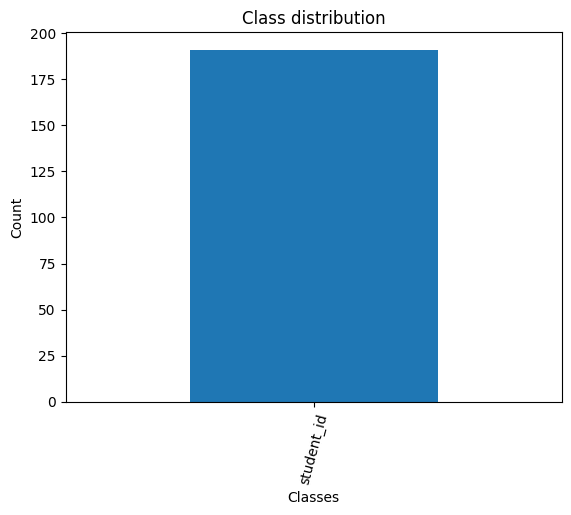

In [16]:
# Get the number of samples for each object class
class_counts = shapes_df['label'].value_counts()

# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_names, rotation=75)  # Set the x-axis tick labels
plt.show()

#### Add a background class

In [17]:
# Prepend a `background` class to the list of class names
class_names = ['background']+class_names

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

0
0  background
1  student_id

### Visualizing Image Annotations

#### Generate a color map

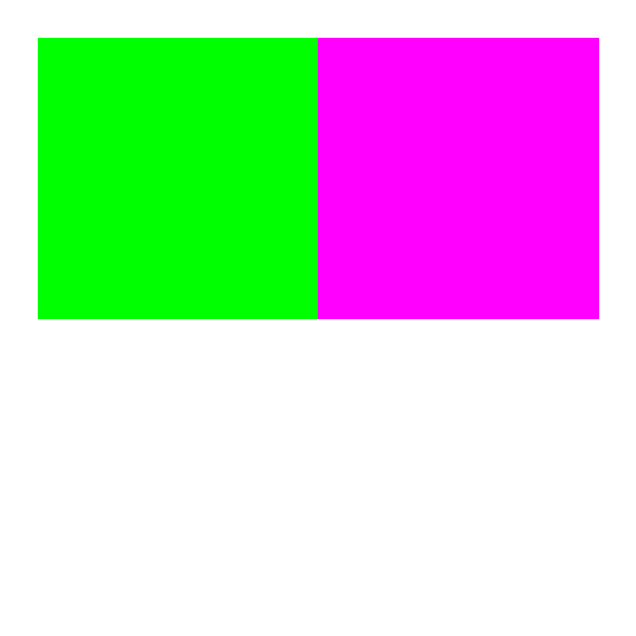

In [18]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [19]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Define the bounding box annotation function

In [20]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

### Selecting a Sample Image

#### Load the sample image

Image Dims: (480, 640)


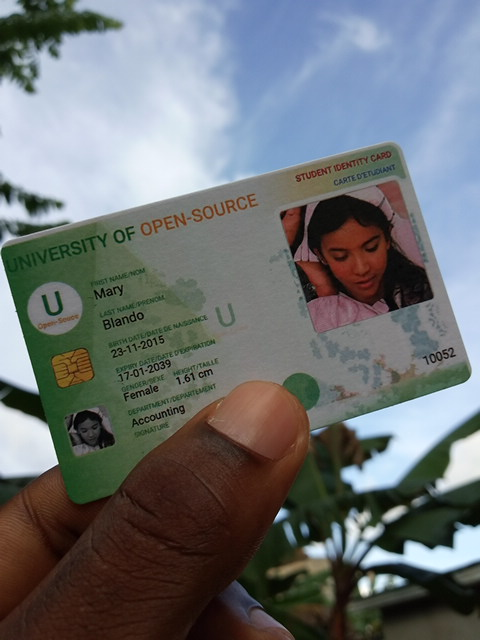

In [21]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[56]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

#### Inspect the corresponding annotation data

In [22]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

10052
version                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              3.21.1
flags                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    {}
shapes       [{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[3.0, 248.57142857142856], [202.04761904761904, 192.38095238095238], [388.71428571428567, 143.8095238095238], [397.2857142857142, 150.47619047619048], [472.5238095238095, 374.2857142857143], [467.7619047619047, 382.85714285714283], [311.57142857142856, 431.4285714285714], [304.9047619047619, 411.4285714285714], [295.3809523809524, 395.23809523809524], [282.04761904761904, 384.76190476190476], [262.04761904761904, 379.04761904761904], [238.23809523809524, 383.8095238095238], [223.9523809523809, 397.1428571428571], [207.76190476190476, 402.85714285714283], [169.66666666666663, 437.1428571428571], [143.95238095238096, 455.23809523809524], [127.76190476190476, 472.38095238095235], [114.42857142857139, 492.38095238095235], [89.66666666666663, 502.85714285714283], [77.28571428571428, 506.66666666666663], [68.71428571428572, 500.9523809523809], [57.28571428571428, 464.76190476190476], [35.38095238095235, 374.2857142857143], [6.809523809523796, 274.2857142857143]], 'shape_type': 'polygon', 'flags': {}}]
lineColor                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

#### Define a function to convert segmentation polygons to images

In [23]:
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)
    
    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

#### Annotate sample image

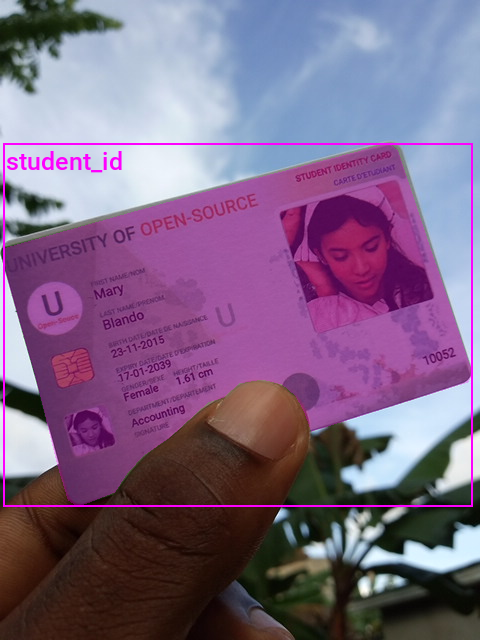

In [24]:
# Extract the labels for the sample
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
# Extract the polygon points for segmentation mask
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
# Format polygon points for PIL
xy_coords = [[tuple(p) for p in points] for points in shape_points]
# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
# Generate bounding box annotations from segmentation masks
bboxes = torchvision.ops.masks_to_boxes(masks)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img), 
    masks=masks, 
    alpha=0.3, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=bboxes, 
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Loading the Mask R-CNN Model

In [25]:
# Initialize a Mask R-CNN model with pretrained weights
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Get the number of input features for the classifier
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(class_names))

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(class_names))

# Set the model's device and data type
model.to(device=device, dtype=dtype);

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'

### Summarizing the Model

In [26]:
test_inp = torch.randn(1, 3, 256, 256).to(device)

summary_df = markdown_to_pandas(f"{get_module_summary(model.eval(), [test_inp])}")

# # Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[summary_df.index == 0]

summary_df.drop(['In size', 'Out size', 'Contains Uninitialized Parameters?'], axis=1)

/home/innom-dt/mambaforge/envs/pytorch-env/lib/python3.11/site-packages/torchtnt/utils/module_summary.py:271: UserWarning: Backward FLOPs are only computed if module foward returns a tensor.
  warnings.warn(


Type # Parameters # Trainable Parameters Size (bytes) Forward FLOPs
0  MaskRCNN       45.9 M                 45.7 M        183 M         331 G

## Preparing the Data

### Training-Validation Split

In [27]:
# Get the list of image IDs
img_keys = list(img_dict.keys())

# Shuffle the image IDs
random.shuffle(img_keys)

# Define the percentage of the images that should be used for training
train_pct = 0.8
val_pct = 0.2

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_keys)*train_pct)
val_split = int(len(img_keys)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_keys = img_keys[:train_split]
val_keys = img_keys[train_split:]

# Print the number of images in the training and validation sets
pd.Series({
    "Training Samples:": len(train_keys),
    "Validation Samples:": len(val_keys)
}).to_frame().style.hide(axis='columns')

### Data Augmentation

#### Set training image size

In [28]:
# Set training image size
train_sz = 512

#### Initialize the transforms

In [29]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

In [30]:
# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

#### Test the transforms

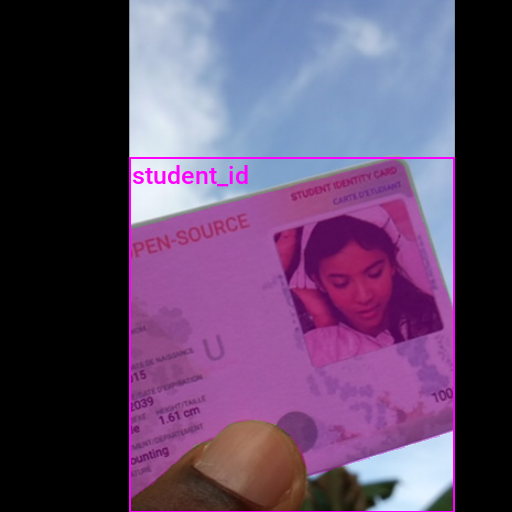

In [31]:
# Extract the labels for the sample
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
# Extract the polygon points for segmentation mask
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
# Format polygon points for PIL
xy_coords = [[tuple(p) for p in points] for points in shape_points]
# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
# Generate bounding box annotations from segmentation masks
bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=sample_img.size[::-1])

# Get colors for dataset sample
sample_colors = [int_colors[i] for i in [class_names.index(label) for label in labels]]

# Prepare mask and bounding box targets
targets = {
    'masks': Mask(masks), 
    'boxes': bboxes, 
    'labels': torch.Tensor([class_names.index(label) for label in labels])
}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img), 
    masks=targets['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=targets['boxes'], 
    labels=[class_names[int(label.item())] for label in targets['labels']], 
    colors=sample_colors
)

# # Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [32]:
class StudentIDDataset(Dataset):
    """
    This class represents a PyTorch Dataset for a collection of images and their annotations.
    The class is designed to load images along with their corresponding segmentation masks, bounding box annotations, and labels.
    """
    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        """
        Constructor for the HagridDataset class.

        Parameters:
        img_keys (list): List of unique identifiers for images.
        annotation_df (DataFrame): DataFrame containing the image annotations.
        img_dict (dict): Dictionary mapping image identifiers to image file paths.
        class_to_idx (dict): Dictionary mapping class labels to indices.
        transforms (callable, optional): Optional transform to be applied on a sample.
        """
        super(Dataset, self).__init__()
        
        self._img_keys = img_keys  # List of image keys
        self._annotation_df = annotation_df  # DataFrame containing annotations
        self._img_dict = img_dict  # Dictionary mapping image keys to image paths
        self._class_to_idx = class_to_idx  # Dictionary mapping class names to class indices
        self._transforms = transforms  # Image transforms to be applied
        
    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
        int: The number of items in the dataset.
        """
        return len(self._img_keys)
        
    def __getitem__(self, index):
        """
        Fetch an item from the dataset at the specified index.

        Parameters:
        index (int): Index of the item to fetch from the dataset.

        Returns:
        tuple: A tuple containing the image and its associated target (annotations).
        """
        # Retrieve the key for the image at the specified index
        img_key = self._img_keys[index]
        # Get the annotations for this image
        annotation = self._annotation_df.loc[img_key]
        # Load the image and its target (segmentation masks, bounding boxes and labels)
        image, target = self._load_image_and_target(annotation)
        target['image_id'] = index
        
        # Apply the transformations, if any
        if self._transforms:
            image, target = self._transforms(image, target)
        
        return image, target

    def _load_image_and_target(self, annotation):
        """
        Load an image and its target (bounding boxes and labels).

        Parameters:
        annotation (pandas.Series): The annotations for an image.

        Returns:
        tuple: A tuple containing the image and a dictionary with 'boxes' and 'labels' keys.
        """
        # Retrieve the file path of the image
        filepath = self._img_dict[annotation.name]
        # Open the image file and convert it to RGB
        image = Image.open(filepath).convert('RGB')
        
        # Convert the class labels to indices
        labels = [shape['label'] for shape in annotation['shapes']]
        labels = torch.Tensor([self._class_to_idx[label] for label in labels])
        labels = labels.to(dtype=torch.int64)

        # Convert polygons to mask images
        shape_points = [shape['points'] for shape in annotation['shapes']]
        xy_coords = [[tuple(p) for p in points] for points in shape_points]
        mask_imgs = [create_polygon_mask(image.size, xy) for xy in xy_coords]
        masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs]))

        # Generate bounding box annotations from segmentation masks
        bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=image.size[::-1])
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(bboxes),), dtype=torch.int64)
                
        return image, {'masks': masks,'boxes': bboxes, 'labels': labels, 'area': area, 'iscrowd': iscrowd}

### Image Transforms

In [33]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

### Initialize Datasets

In [34]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the datasets using the defined transformations
train_dataset = StudentIDDataset(train_keys, annotation_df, img_dict, class_to_idx, train_tfms)
valid_dataset = StudentIDDataset(val_keys, annotation_df, img_dict, class_to_idx, valid_tfms)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')

### Inspect Samples

#### Inspect training set sample

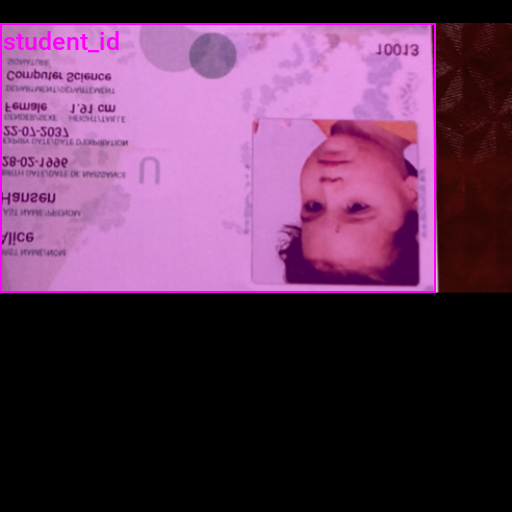

In [35]:
dataset_sample = train_dataset[0]

# Get colors for dataset sample
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks( 
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    masks=dataset_sample[1]['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the sample image with bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)

#### Inspect validation set sample

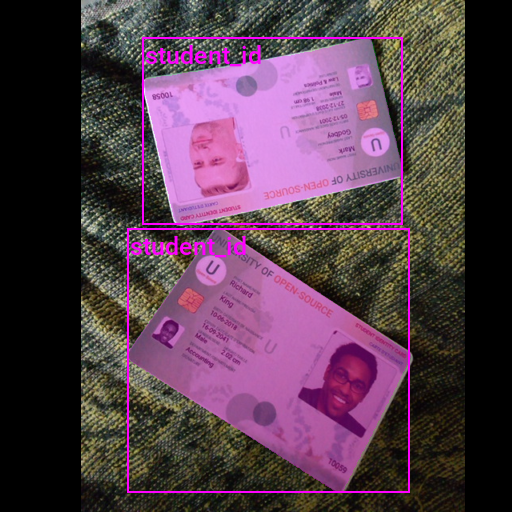

In [36]:
dataset_sample = valid_dataset[0]

# Get colors for dataset sample
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8),
    masks=dataset_sample[1]['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the sample image with bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)

### Initialize DataLoaders

In [37]:
# Set the training batch size
bs = 4

# Set the number of worker processes for loading data.
num_workers = multiprocessing.cpu_count()//2

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': 'cuda' in device,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': device if 'cuda' in device else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
    'collate_fn': lambda batch: tuple(zip(*batch)),
}

# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

# Print the number of batches in the training and validation DataLoaders
pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in validation DataLoader:': len(valid_dataloader)}
).to_frame().style.hide(axis='columns')

## Fine-tuning the Model

### Define the Training Loop

In [38]:
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, epoch_id, is_training):
    """
    Function to run a single training or evaluation epoch.
    
    Args:
        model: A PyTorch model to train or evaluate.
        dataloader: A PyTorch DataLoader providing the data.
        optimizer: The optimizer to use for training the model.
        loss_func: The loss function used for training.
        device: The device (CPU or GPU) to run the model on.
        scaler: Gradient scaler for mixed-precision training.
        is_training: Boolean flag indicating whether the model is in training or evaluation mode.
    
    Returns:
        The average loss for the epoch.
    """
    # Set the model to training mode
    model.train()
    
    epoch_loss = 0  # Initialize the total loss for this epoch
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")  # Initialize a progress bar
    
    # Loop over the data
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device
        inputs = torch.stack(inputs).to(device)
        
        # Forward pass with Automatic Mixed Precision (AMP) context manager
        with autocast(torch.device(device).type):
            if is_training:
                losses = model(inputs.to(device), move_data_to_device(targets, device))
            else:
                with torch.no_grad():
                    losses = model(inputs.to(device), move_data_to_device(targets, device))
                    # print(losses)
        
            # Compute the loss
            loss = sum([loss for loss in losses.values()])  # Sum up the losses

        # If in training mode, backpropagate the error and update the weights
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                
            optimizer.zero_grad()

        # Update the total loss
        loss_item = loss.item()
        epoch_loss += loss_item
        
        # Update the progress bar
        progress_bar_dict = dict(loss=loss_item, avg_loss=epoch_loss/(batch_id+1))
        if is_training:
            progress_bar_dict.update(lr=lr_scheduler.get_last_lr()[0])
        progress_bar.set_postfix(progress_bar_dict)
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message

    # Cleanup and close the progress bar 
    progress_bar.close()
    
    # Return the average loss for this epoch
    return epoch_loss / (batch_id + 1)

def train_loop(model, 
               train_dataloader, 
               valid_dataloader, 
               optimizer,  
               lr_scheduler, 
               device, 
               epochs, 
               checkpoint_path, 
               use_scaler=False):
    """
    Main training loop.
    
    Args:
        model: A PyTorch model to train.
        train_dataloader: A PyTorch DataLoader providing the training data.
        valid_dataloader: A PyTorch DataLoader providing the validation data.
        optimizer: The optimizer to use for training the model.
        lr_scheduler: The learning rate scheduler.
        device: The device (CPU or GPU) to run the model on.
        epochs: The number of epochs to train for.
        checkpoint_path: The path where to save the best model checkpoint.
        use_scaler: Whether to scale graidents when using a CUDA device
    
    Returns:
        None
    """
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')  # Initialize the best validation loss

    # Loop over the epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run a training epoch and get the training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, epoch, is_training=True)
        # Run an evaluation epoch and get the validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, device, scaler, epoch, is_training=False)
            evaluate(model, valid_dataloader, device=device)

        # If the validation loss is lower than the best validation loss seen so far, save the model checkpoint
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

            # Save metadata about the training process
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss, 
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

### Set the Model Checkpoint Path

In [39]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

pytorch-mask-r-cnn-instance-segmentation/2024-04-25_11-40-29/maskrcnn_resnet50_fpn_v2.pth


### Save the Color Map

In [40]:
# Create a color map and write it to a JSON file
color_map = {'items': [{'label': label, 'color': color} for label, color in zip(class_names, colors)]}
with open(f"{checkpoint_dir}/{dataset_path.name}-colormap.json", "w") as file:
    json.dump(color_map, file)

# Print the name of the file that the color map was written to
print(f"{checkpoint_dir}/{dataset_path.name}-colormap.json")

pytorch-mask-r-cnn-instance-segmentation/2024-04-25_11-40-29/student-id-colormap.json


### Configure the Training Parameters

In [41]:
# Learning rate for the model
lr = 3e-4

# Number of training epochs
epochs = 40

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                   max_lr=lr, 
                                                   total_steps=epochs*len(train_dataloader))

### Train the Model

In [42]:
train_loop(model=model, 
           train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           optimizer=optimizer, 
           lr_scheduler=lr_scheduler, 
           device=torch.device(device), 
           epochs=epochs, 
           checkpoint_path=checkpoint_path,
           use_scaler=True)

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:02  model_time: 0.1410 (0.1410)  evaluator_time: 0.0308 (0.0308)  time: 0.2736  data: 0.1011  max mem: 3218
Test:  [7/8]  eta: 0:00:00  model_time: 0.0886 (0.0993)  evaluator_time: 0.0206 (0.0228)  time: 0.1357  data: 0.0127  max mem: 3218
Test: Total time: 0:00:01 (0.1357 s / it)
Averaged stats: model_time: 0.0886 (0.0993)  evaluator_time: 0.0206 (0.0228)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.1019 (0.1019)  evaluator_time: 0.0385 (0.0385)  time: 0.2295  data: 0.0884  max mem: 3218
Test:  [7/8]  eta: 0:00:00  model_time: 0.0971 (0.0938)  evaluator_time: 0.0295 (0.0305)  time: 0.1362  data: 0.0111  max mem: 3218
Test: Total time: 0:00:01 (0.1363 s / it)
Averaged stats: model_time: 0.0971 (0.0938)  evaluator_time: 0.0295 (0.0305)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.970
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0788 (0.0788)  evaluator_time: 0.0088 (0.0088)  time: 0.1817  data: 0.0934  max mem: 3249
Test:  [7/8]  eta: 0:00:00  model_time: 0.0782 (0.0740)  evaluator_time: 0.0077 (0.0078)  time: 0.0940  data: 0.0117  max mem: 3249
Test: Total time: 0:00:00 (0.0941 s / it)
Averaged stats: model_time: 0.0782 (0.0740)  evaluator_time: 0.0077 (0.0078)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.707
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0742 (0.0742)  evaluator_time: 0.0079 (0.0079)  time: 0.1787  data: 0.0959  max mem: 3265
Test:  [7/8]  eta: 0:00:00  model_time: 0.0738 (0.0704)  evaluator_time: 0.0059 (0.0057)  time: 0.0887  data: 0.0120  max mem: 3265
Test: Total time: 0:00:00 (0.0888 s / it)
Averaged stats: model_time: 0.0738 (0.0704)  evaluator_time: 0.0059 (0.0057)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0745 (0.0745)  evaluator_time: 0.0081 (0.0081)  time: 0.1610  data: 0.0777  max mem: 3265
Test:  [7/8]  eta: 0:00:00  model_time: 0.0727 (0.0689)  evaluator_time: 0.0058 (0.0058)  time: 0.0850  data: 0.0098  max mem: 3265
Test: Total time: 0:00:00 (0.0851 s / it)
Averaged stats: model_time: 0.0727 (0.0689)  evaluator_time: 0.0058 (0.0058)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.997
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0711 (0.0711)  evaluator_time: 0.0058 (0.0058)  time: 0.1776  data: 0.1000  max mem: 3302
Test:  [7/8]  eta: 0:00:00  model_time: 0.0711 (0.0674)  evaluator_time: 0.0058 (0.0054)  time: 0.0859  data: 0.0125  max mem: 3302
Test: Total time: 0:00:00 (0.0860 s / it)
Averaged stats: model_time: 0.0711 (0.0674)  evaluator_time: 0.0058 (0.0054)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.871
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0715 (0.0715)  evaluator_time: 0.0058 (0.0058)  time: 0.1804  data: 0.1025  max mem: 3302
Test:  [7/8]  eta: 0:00:00  model_time: 0.0715 (0.0681)  evaluator_time: 0.0048 (0.0053)  time: 0.0869  data: 0.0129  max mem: 3302
Test: Total time: 0:00:00 (0.0870 s / it)
Averaged stats: model_time: 0.0715 (0.0681)  evaluator_time: 0.0048 (0.0053)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.920
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0831 (0.0831)  evaluator_time: 0.0133 (0.0133)  time: 0.1811  data: 0.0841  max mem: 3302
Test:  [7/8]  eta: 0:00:00  model_time: 0.0756 (0.0727)  evaluator_time: 0.0097 (0.0095)  time: 0.0934  data: 0.0106  max mem: 3302
Test: Total time: 0:00:00 (0.0935 s / it)
Averaged stats: model_time: 0.0756 (0.0727)  evaluator_time: 0.0097 (0.0095)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.937
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0753 (0.0753)  evaluator_time: 0.0100 (0.0100)  time: 0.1873  data: 0.1014  max mem: 3302
Test:  [7/8]  eta: 0:00:00  model_time: 0.0738 (0.0701)  evaluator_time: 0.0096 (0.0084)  time: 0.0919  data: 0.0127  max mem: 3302
Test: Total time: 0:00:00 (0.0920 s / it)
Averaged stats: model_time: 0.0738 (0.0701)  evaluator_time: 0.0096 (0.0084)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0772 (0.0772)  evaluator_time: 0.0114 (0.0114)  time: 0.1827  data: 0.0934  max mem: 3302
Test:  [7/8]  eta: 0:00:00  model_time: 0.0740 (0.0695)  evaluator_time: 0.0079 (0.0080)  time: 0.0898  data: 0.0117  max mem: 3302
Test: Total time: 0:00:00 (0.0899 s / it)
Averaged stats: model_time: 0.0740 (0.0695)  evaluator_time: 0.0079 (0.0080)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.861
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0723 (0.0723)  evaluator_time: 0.0058 (0.0058)  time: 0.1685  data: 0.0896  max mem: 3302
Test:  [7/8]  eta: 0:00:00  model_time: 0.0721 (0.0686)  evaluator_time: 0.0061 (0.0063)  time: 0.0868  data: 0.0113  max mem: 3302
Test: Total time: 0:00:00 (0.0868 s / it)
Averaged stats: model_time: 0.0721 (0.0686)  evaluator_time: 0.0061 (0.0063)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0733 (0.0733)  evaluator_time: 0.0069 (0.0069)  time: 0.1762  data: 0.0953  max mem: 3302
Test:  [7/8]  eta: 0:00:00  model_time: 0.0717 (0.0681)  evaluator_time: 0.0059 (0.0055)  time: 0.0861  data: 0.0120  max mem: 3302
Test: Total time: 0:00:00 (0.0862 s / it)
Averaged stats: model_time: 0.0717 (0.0681)  evaluator_time: 0.0059 (0.0055)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.842
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0745 (0.0745)  evaluator_time: 0.0090 (0.0090)  time: 0.1730  data: 0.0888  max mem: 3302
Test:  [7/8]  eta: 0:00:00  model_time: 0.0723 (0.0687)  evaluator_time: 0.0062 (0.0069)  time: 0.0874  data: 0.0112  max mem: 3302
Test: Total time: 0:00:00 (0.0875 s / it)
Averaged stats: model_time: 0.0723 (0.0687)  evaluator_time: 0.0062 (0.0069)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0767 (0.0767)  evaluator_time: 0.0064 (0.0064)  time: 0.1774  data: 0.0936  max mem: 3302
Test:  [7/8]  eta: 0:00:00  model_time: 0.0761 (0.0704)  evaluator_time: 0.0051 (0.0051)  time: 0.0879  data: 0.0118  max mem: 3302
Test: Total time: 0:00:00 (0.0880 s / it)
Averaged stats: model_time: 0.0761 (0.0704)  evaluator_time: 0.0051 (0.0051)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.967
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0736 (0.0736)  evaluator_time: 0.0063 (0.0063)  time: 0.1808  data: 0.1003  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0707 (0.0674)  evaluator_time: 0.0040 (0.0042)  time: 0.0848  data: 0.0126  max mem: 3335
Test: Total time: 0:00:00 (0.0848 s / it)
Averaged stats: model_time: 0.0707 (0.0674)  evaluator_time: 0.0040 (0.0042)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0717 (0.0717)  evaluator_time: 0.0062 (0.0062)  time: 0.1689  data: 0.0904  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0716 (0.0671)  evaluator_time: 0.0047 (0.0049)  time: 0.0839  data: 0.0113  max mem: 3335
Test: Total time: 0:00:00 (0.0840 s / it)
Averaged stats: model_time: 0.0716 (0.0671)  evaluator_time: 0.0047 (0.0049)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.825
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0733 (0.0733)  evaluator_time: 0.0070 (0.0070)  time: 0.1800  data: 0.0989  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0714 (0.0676)  evaluator_time: 0.0052 (0.0056)  time: 0.0862  data: 0.0124  max mem: 3335
Test: Total time: 0:00:00 (0.0863 s / it)
Averaged stats: model_time: 0.0714 (0.0676)  evaluator_time: 0.0052 (0.0056)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.867
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0723 (0.0723)  evaluator_time: 0.0053 (0.0053)  time: 0.1628  data: 0.0845  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0712 (0.0673)  evaluator_time: 0.0049 (0.0047)  time: 0.0832  data: 0.0106  max mem: 3335
Test: Total time: 0:00:00 (0.0832 s / it)
Averaged stats: model_time: 0.0712 (0.0673)  evaluator_time: 0.0049 (0.0047)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.964
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0729 (0.0729)  evaluator_time: 0.0057 (0.0057)  time: 0.1621  data: 0.0829  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0714 (0.0673)  evaluator_time: 0.0045 (0.0047)  time: 0.0830  data: 0.0104  max mem: 3335
Test: Total time: 0:00:00 (0.0831 s / it)
Averaged stats: model_time: 0.0714 (0.0673)  evaluator_time: 0.0045 (0.0047)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.548
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0729 (0.0729)  evaluator_time: 0.0065 (0.0065)  time: 0.1713  data: 0.0912  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0709 (0.0668)  evaluator_time: 0.0044 (0.0044)  time: 0.0832  data: 0.0114  max mem: 3335
Test: Total time: 0:00:00 (0.0833 s / it)
Averaged stats: model_time: 0.0709 (0.0668)  evaluator_time: 0.0044 (0.0044)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.869
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.215
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0727 (0.0727)  evaluator_time: 0.0058 (0.0058)  time: 0.1675  data: 0.0884  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0712 (0.0668)  evaluator_time: 0.0049 (0.0048)  time: 0.0833  data: 0.0111  max mem: 3335
Test: Total time: 0:00:00 (0.0834 s / it)
Averaged stats: model_time: 0.0712 (0.0668)  evaluator_time: 0.0049 (0.0048)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.843
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0722 (0.0722)  evaluator_time: 0.0053 (0.0053)  time: 0.1677  data: 0.0896  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0702 (0.0662)  evaluator_time: 0.0039 (0.0040)  time: 0.0820  data: 0.0112  max mem: 3335
Test: Total time: 0:00:00 (0.0821 s / it)
Averaged stats: model_time: 0.0702 (0.0662)  evaluator_time: 0.0039 (0.0040)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.336
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0744 (0.0744)  evaluator_time: 0.0061 (0.0061)  time: 0.1755  data: 0.0943  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0712 (0.0673)  evaluator_time: 0.0045 (0.0046)  time: 0.0844  data: 0.0118  max mem: 3335
Test: Total time: 0:00:00 (0.0844 s / it)
Averaged stats: model_time: 0.0712 (0.0673)  evaluator_time: 0.0045 (0.0046)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.476
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.941
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0810 (0.0810)  evaluator_time: 0.0083 (0.0083)  time: 0.1682  data: 0.0782  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0720 (0.0688)  evaluator_time: 0.0048 (0.0057)  time: 0.0850  data: 0.0098  max mem: 3335
Test: Total time: 0:00:00 (0.0851 s / it)
Averaged stats: model_time: 0.0720 (0.0688)  evaluator_time: 0.0048 (0.0057)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.549
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.928
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0725 (0.0725)  evaluator_time: 0.0048 (0.0048)  time: 0.1563  data: 0.0784  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0711 (0.0670)  evaluator_time: 0.0039 (0.0041)  time: 0.0815  data: 0.0098  max mem: 3335
Test: Total time: 0:00:00 (0.0816 s / it)
Averaged stats: model_time: 0.0711 (0.0670)  evaluator_time: 0.0039 (0.0041)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.791
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0728 (0.0728)  evaluator_time: 0.0055 (0.0055)  time: 0.1815  data: 0.1026  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0701 (0.0665)  evaluator_time: 0.0039 (0.0043)  time: 0.0843  data: 0.0129  max mem: 3335
Test: Total time: 0:00:00 (0.0844 s / it)
Averaged stats: model_time: 0.0701 (0.0665)  evaluator_time: 0.0039 (0.0043)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.908
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.541
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0724 (0.0724)  evaluator_time: 0.0053 (0.0053)  time: 0.1667  data: 0.0883  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0707 (0.0670)  evaluator_time: 0.0041 (0.0043)  time: 0.0830  data: 0.0111  max mem: 3335
Test: Total time: 0:00:00 (0.0830 s / it)
Averaged stats: model_time: 0.0707 (0.0670)  evaluator_time: 0.0041 (0.0043)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.897
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0715 (0.0715)  evaluator_time: 0.0043 (0.0043)  time: 0.1666  data: 0.0900  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0715 (0.0667)  evaluator_time: 0.0039 (0.0039)  time: 0.0826  data: 0.0113  max mem: 3335
Test: Total time: 0:00:00 (0.0826 s / it)
Averaged stats: model_time: 0.0715 (0.0667)  evaluator_time: 0.0039 (0.0039)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0719 (0.0719)  evaluator_time: 0.0039 (0.0039)  time: 0.1710  data: 0.0945  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0710 (0.0668)  evaluator_time: 0.0035 (0.0038)  time: 0.0830  data: 0.0119  max mem: 3335
Test: Total time: 0:00:00 (0.0831 s / it)
Averaged stats: model_time: 0.0710 (0.0668)  evaluator_time: 0.0035 (0.0038)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.994
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0713 (0.0713)  evaluator_time: 0.0048 (0.0048)  time: 0.1659  data: 0.0891  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0705 (0.0668)  evaluator_time: 0.0040 (0.0039)  time: 0.0826  data: 0.0112  max mem: 3335
Test: Total time: 0:00:00 (0.0826 s / it)
Averaged stats: model_time: 0.0705 (0.0668)  evaluator_time: 0.0040 (0.0039)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.948
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0722 (0.0722)  evaluator_time: 0.0048 (0.0048)  time: 0.1786  data: 0.1009  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0706 (0.0669)  evaluator_time: 0.0036 (0.0041)  time: 0.0843  data: 0.0127  max mem: 3335
Test: Total time: 0:00:00 (0.0844 s / it)
Averaged stats: model_time: 0.0706 (0.0669)  evaluator_time: 0.0036 (0.0041)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.834
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0772 (0.0772)  evaluator_time: 0.0051 (0.0051)  time: 0.1811  data: 0.0982  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0744 (0.0700)  evaluator_time: 0.0036 (0.0039)  time: 0.0868  data: 0.0123  max mem: 3335
Test: Total time: 0:00:00 (0.0869 s / it)
Averaged stats: model_time: 0.0744 (0.0700)  evaluator_time: 0.0036 (0.0039)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.742
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0758 (0.0758)  evaluator_time: 0.0049 (0.0049)  time: 0.1886  data: 0.1072  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0715 (0.0690)  evaluator_time: 0.0035 (0.0039)  time: 0.0869  data: 0.0134  max mem: 3335
Test: Total time: 0:00:00 (0.0870 s / it)
Averaged stats: model_time: 0.0715 (0.0690)  evaluator_time: 0.0035 (0.0039)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.885
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0837 (0.0837)  evaluator_time: 0.0057 (0.0057)  time: 0.1826  data: 0.0924  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0768 (0.0739)  evaluator_time: 0.0046 (0.0046)  time: 0.0907  data: 0.0116  max mem: 3335
Test: Total time: 0:00:00 (0.0908 s / it)
Averaged stats: model_time: 0.0768 (0.0739)  evaluator_time: 0.0046 (0.0046)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.865
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0729 (0.0729)  evaluator_time: 0.0049 (0.0049)  time: 0.1751  data: 0.0967  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0730 (0.0702)  evaluator_time: 0.0040 (0.0041)  time: 0.0870  data: 0.0121  max mem: 3335
Test: Total time: 0:00:00 (0.0871 s / it)
Averaged stats: model_time: 0.0730 (0.0702)  evaluator_time: 0.0040 (0.0041)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.835
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0773 (0.0773)  evaluator_time: 0.0053 (0.0053)  time: 0.1710  data: 0.0877  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0725 (0.0692)  evaluator_time: 0.0038 (0.0041)  time: 0.0849  data: 0.0110  max mem: 3335
Test: Total time: 0:00:00 (0.0850 s / it)
Averaged stats: model_time: 0.0725 (0.0692)  evaluator_time: 0.0038 (0.0041)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.920
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0737 (0.0737)  evaluator_time: 0.0053 (0.0053)  time: 0.1716  data: 0.0919  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0707 (0.0667)  evaluator_time: 0.0036 (0.0039)  time: 0.0828  data: 0.0115  max mem: 3335
Test: Total time: 0:00:00 (0.0828 s / it)
Averaged stats: model_time: 0.0707 (0.0667)  evaluator_time: 0.0036 (0.0039)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.850
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0712 (0.0712)  evaluator_time: 0.0049 (0.0049)  time: 0.1787  data: 0.1018  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0709 (0.0668)  evaluator_time: 0.0035 (0.0039)  time: 0.0840  data: 0.0128  max mem: 3335
Test: Total time: 0:00:00 (0.0841 s / it)
Averaged stats: model_time: 0.0709 (0.0668)  evaluator_time: 0.0035 (0.0039)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.867
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0721 (0.0721)  evaluator_time: 0.0049 (0.0049)  time: 0.1560  data: 0.0782  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0709 (0.0668)  evaluator_time: 0.0039 (0.0040)  time: 0.0812  data: 0.0098  max mem: 3335
Test: Total time: 0:00:00 (0.0813 s / it)
Averaged stats: model_time: 0.0709 (0.0668)  evaluator_time: 0.0039 (0.0040)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.880
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0730 (0.0730)  evaluator_time: 0.0051 (0.0051)  time: 0.1758  data: 0.0970  max mem: 3335
Test:  [7/8]  eta: 0:00:00  model_time: 0.0713 (0.0676)  evaluator_time: 0.0039 (0.0041)  time: 0.0844  data: 0.0122  max mem: 3335
Test: Total time: 0:00:00 (0.0845 s / it)
Averaged stats: model_time: 0.0713 (0.0676)  evaluator_time: 0.0039 (0.0041)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

## Making Predictions with the Model

### Preparing Input Data

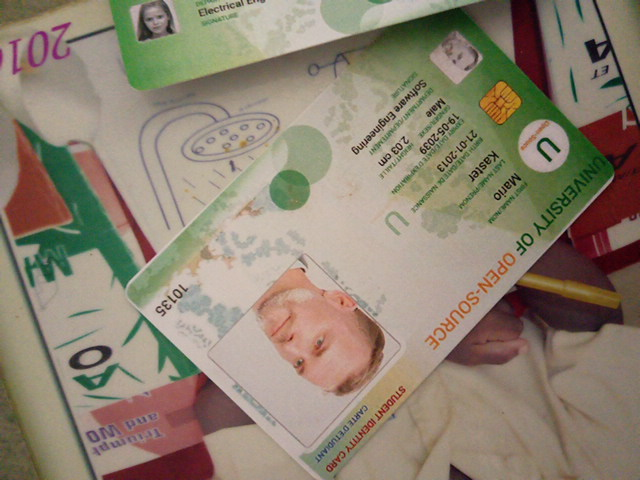

In [43]:
# Choose a random item from the validation set
file_id = random.choice(val_keys)

# Retrieve the image file path associated with the file ID
test_file = img_dict[file_id]

# Open the test file
test_img = Image.open(test_file).convert('RGB')

# Resize the test image
input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(input_img.size)

display(test_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_img.size,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

#### Get the target annotation data

In [44]:
# Extract the polygon points for segmentation mask
target_shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
# Format polygon points for PIL
target_xy_coords = [[tuple(p) for p in points] for points in target_shape_points]
# Generate mask images from polygons
target_mask_imgs = [create_polygon_mask(test_img.size, xy) for xy in target_xy_coords]
# Convert mask images to tensors
target_masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in target_mask_imgs]))

# Get the target labels and bounding boxes
target_labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
target_bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(target_masks), format='xyxy', canvas_size=test_img.size[::-1])

#### Pass the input data to the model

In [45]:
# Set the model to evaluation mode
model.eval();

# Ensure the model and input data are on the same device
model.to(device)
input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)

# Make a prediction with the model
with torch.no_grad():
    model_output = model(input_tensor)

#### Filter the model output

In [46]:
# Set the confidence threshold
threshold = 0.5

# Move model output to the CPU
model_output = move_data_to_device(model_output, 'cpu')

# Filter the output based on the confidence threshold
scores_mask = model_output[0]['scores'] > threshold

# Scale the predicted bounding boxes
pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask]*min_img_scale, format='xyxy', canvas_size=input_img.size[::-1])

# Get the class names for the predicted label indices
pred_labels = [class_names[int(label)] for label in model_output[0]['labels'][scores_mask]]

# Extract the confidence scores
pred_scores = model_output[0]['scores']

# Scale and stack the predicted segmentation masks
pred_masks = F.interpolate(model_output[0]['masks'][scores_mask], size=test_img.size[::-1])
pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])

#### Annotate the image using the model predictions 

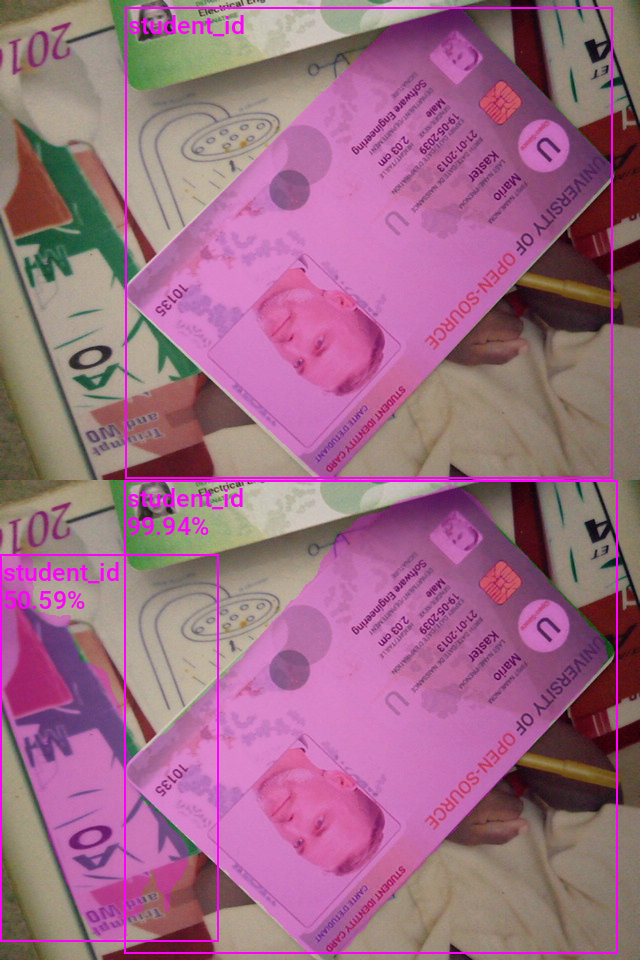

In [47]:
# Get the annotation colors for the targets and predictions
target_colors=[int_colors[i] for i in [class_names.index(label) for label in target_labels]]
pred_colors=[int_colors[i] for i in [class_names.index(label) for label in pred_labels]]

# Convert the test images to a tensor
img_tensor = transforms.PILToTensor()(test_img)

# Annotate the test image with the target segmentation masks
annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=target_masks, alpha=0.3, colors=target_colors)
# Annotate the test image with the target bounding boxes
annotated_tensor = draw_bboxes(image=annotated_tensor, boxes=target_bboxes, labels=target_labels, colors=target_colors)
# Display the annotated test image
annotated_test_img = tensor_to_pil(annotated_tensor)

# Annotate the test image with the predicted segmentation masks
annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=pred_masks, alpha=0.3, colors=pred_colors)
# Annotate the test image with the predicted labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=pred_bboxes, 
    labels=[f"{label}\n{prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)],
    colors=pred_colors
)

# Display the annotated test image with the predicted bounding boxes
display(stack_imgs([annotated_test_img, tensor_to_pil(annotated_tensor)]))

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Target BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(target_labels, np.round(target_bboxes.numpy(), decimals=3))],
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(pred_labels, pred_bboxes.round(decimals=3).numpy())],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)]
}).to_frame().style.hide(axis='columns')